## Problem statement:

To build a CNN based model which can accurately detect food.

[Dataset is taken from kaggle.](https://www.kaggle.com/rajaraman6195/recipes)

### About this Dataset
This is a list of different food listings of images. The dataset includes the set of images for each recipes.

The dataset contains 5 sub-directories of food images.
- biryani
- burger
- dosa
- idly
- pizza

### Importing all the important libraries

In [8]:
import os
import pathlib
from glob import glob
import fnmatch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [10]:
! cp -R ../input/recipes ./newrecipes

In [11]:
data_dir_path = "./newrecipes/"

In [12]:
# import shutil
# shutil.rmtree(data_dir_path)

In [13]:
num_skipped = 0

for folder_name in ['briyani', 'burger', 'dosa', 'idly', 'pizza']:
    folder_path = os.path.join(data_dir_path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 74 images


In [14]:
# Defining the path for train and \test images
data_dir_train = pathlib.Path(data_dir_path)

### Create a dataset

Define some parameters for the loader:

In [15]:
IMAGE_SIZE = 250
BATCH_SIZE = 32
CHANNELS = 3

In [137]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_path,
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2691 files belonging to 5 classes.


In [17]:
def get_dataset_partition_tf(ds, train_split=0.70, val_split=0.20, test_split=0.10, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [18]:
train_ds, test_ds, val_ds = get_dataset_partition_tf(dataset)

In [19]:
print("Training size:", len(train_ds)*BATCH_SIZE)
print("Validation size:", len(val_ds)*BATCH_SIZE)
print("Testing size:", len(test_ds)*BATCH_SIZE)

Training size: 480
Validation size: 128
Testing size: 96


In [20]:
class_names = dataset.class_names
class_names

['briyani', 'burger', 'dosa', 'idly', 'pizza']

### Visualize the data
#### Visualize one instance of all  classes present in the dataset

In [21]:
temp_class = []
temp_dict = {}
for images, labels in train_ds:
    for i, val in enumerate(class_names):
        if class_names[labels[i]] not in temp_class:
            temp_class.append(class_names[labels[i]])
            temp_dict[class_names[labels[i]]] = images[i].numpy().astype("uint8")
    if len(temp_class) == len(class_names):
        break

2021-10-28 13:42:29.915584: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


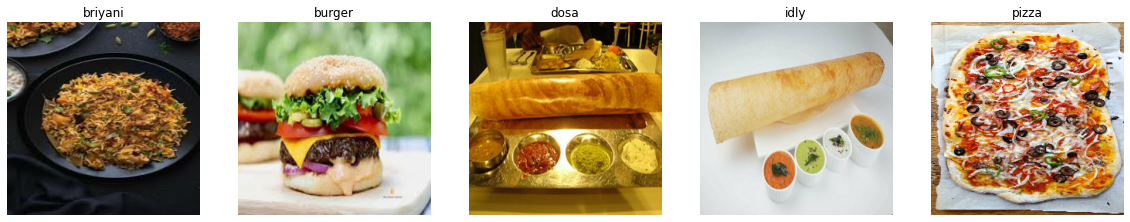

In [22]:
plt.figure(figsize=(20, 5))
for i in range(len(class_names)):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(temp_dict[class_names[i]])
    plt.title(class_names[i])
    plt.axis("off")

**Keeps the images in memory**

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data normalization

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data augmentation

In [25]:
data_augmentation = keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),    
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.25),

])

Let's visualize augmented examples by applying data augmentation to the same image several times:

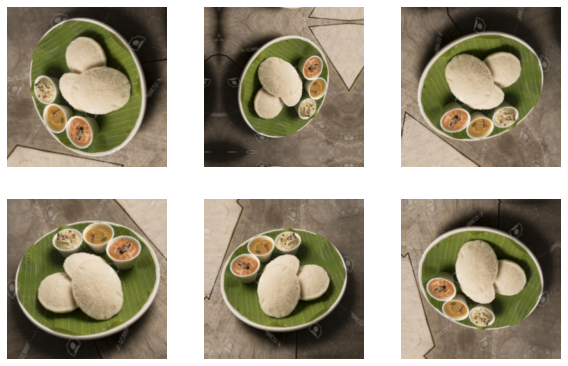

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [27]:
# Function to visualize training result
def visualize_train_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model 1

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)
print("input_shape", input_shape)

input_shape (32, 250, 250, 3)


In [29]:
def define_model1():
    model = Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(256, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.build(input_shape)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [30]:
model_1 = define_model1()

In [31]:
# View the summary of all layers
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 250, 250, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 250, 250, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 248, 248, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 124, 124, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 122, 122, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 61, 61, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 59, 59, 128)        

In [32]:
earlystop = EarlyStopping(monitor='val_loss', patience=15)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, cooldown=1, verbose=1)

In [33]:
%%time
EPOCHS = 40

history1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[LR]
)

Epoch 1/40


2021-10-28 13:42:49.623658: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


15/15 [==============================] - 8s 363ms/step - loss: 2.3613 - accuracy: 0.2548 - val_loss: 1.5133 - val_accuracy: 0.2812
Epoch 2/40
15/15 [==============================] - 1s 45ms/step - loss: 1.3536 - accuracy: 0.4176 - val_loss: 1.3552 - val_accuracy: 0.4062
Epoch 3/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2660 - accuracy: 0.4454 - val_loss: 1.3164 - val_accuracy: 0.4844
Epoch 4/40
15/15 [==============================] - 1s 42ms/step - loss: 1.1240 - accuracy: 0.5653 - val_loss: 1.0998 - val_accuracy: 0.5547
Epoch 5/40
15/15 [==============================] - 1s 42ms/step - loss: 0.9429 - accuracy: 0.6467 - val_loss: 1.1481 - val_accuracy: 0.4844
Epoch 6/40
15/15 [==============================] - 1s 42ms/step - loss: 0.9666 - accuracy: 0.6253 - val_loss: 1.3153 - val_accuracy: 0.4688
Epoch 7/40
15/15 [==============================] - 1s 41ms/step - loss: 0.9484 - accuracy: 0.6488 - val_loss: 0.9258 - val_accuracy: 0.6328
Epoch 8/40
15/15 [=====

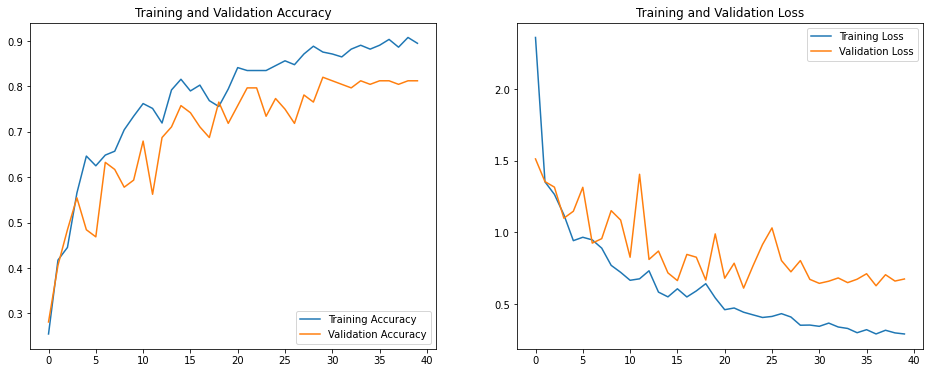

In [34]:
visualize_train_result(history1)

### Findings:
- Training accuracy is 89% and validation accuracy 81%.
- Model is slightly overfitting.
- Let's add dropout to next model and observe the result.

## Model 2


In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
print("input_shape", input_shape)

input_shape (32, 250, 250, 3)


In [36]:
def define_model2():
    model = Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.20),

        layers.Flatten(),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.20),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.build(input_shape)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [37]:
model_2 = define_model2()

In [38]:
# View the summary of all layers
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 250, 250, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (32, 248, 248, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (32, 124, 124, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (32, 122, 122, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (32, 61, 61, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (32, 59, 59, 128)        

In [39]:
%%time
EPOCHS = 40

history2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[LR, earlystop]
)

Epoch 1/40
15/15 [==============================] - 2s 50ms/step - loss: 3.3909 - accuracy: 0.2484 - val_loss: 1.4734 - val_accuracy: 0.3125
Epoch 2/40
15/15 [==============================] - 1s 42ms/step - loss: 1.3028 - accuracy: 0.4433 - val_loss: 1.2129 - val_accuracy: 0.5234
Epoch 3/40
15/15 [==============================] - 1s 42ms/step - loss: 1.1741 - accuracy: 0.5567 - val_loss: 1.0978 - val_accuracy: 0.5625
Epoch 4/40
15/15 [==============================] - 1s 42ms/step - loss: 1.1240 - accuracy: 0.5717 - val_loss: 1.0784 - val_accuracy: 0.5547
Epoch 5/40
15/15 [==============================] - 1s 43ms/step - loss: 0.9537 - accuracy: 0.6338 - val_loss: 1.1482 - val_accuracy: 0.5312
Epoch 6/40
15/15 [==============================] - 1s 42ms/step - loss: 0.8890 - accuracy: 0.6617 - val_loss: 0.9350 - val_accuracy: 0.6328
Epoch 7/40
15/15 [==============================] - 1s 42ms/step - loss: 0.7456 - accuracy: 0.7195 - val_loss: 1.0868 - val_accuracy: 0.5781
Epoch 8/40
15

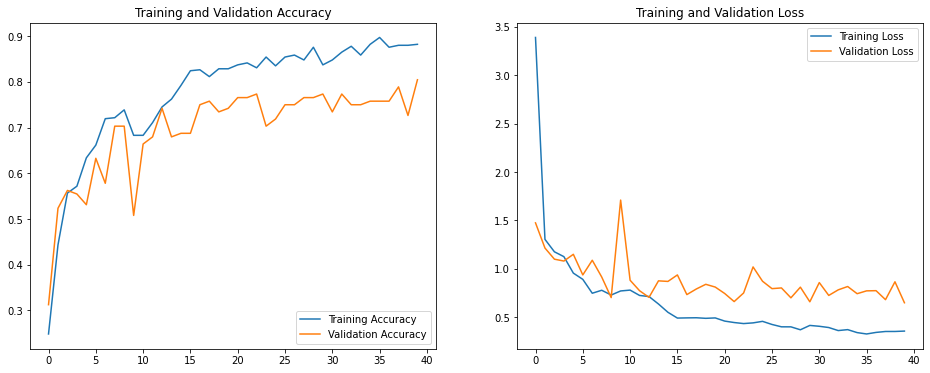

In [40]:
visualize_train_result(history2)

### Findings:
- Training accuracy is 88% and validation accuracy 80%.
- Let's add new layer to next model and observe the result.

## Model 3


In [47]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
print("input_shape", input_shape)

input_shape (32, 250, 250, 3)


In [48]:
def define_model4():
    model = Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.20),

        layers.Flatten(),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.30),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.build(input_shape)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [49]:
model_4 = define_model4()

In [50]:
# View the summary of all layers
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 250, 250, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (32, 248, 248, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (32, 124, 124, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (32, 122, 122, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (32, 61, 61, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (32, 59, 59, 64)         

In [51]:
%%time
EPOCHS = 40

history4 = model_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[LR, earlystop]
)

Epoch 1/40
15/15 [==============================] - 2s 51ms/step - loss: 1.6584 - accuracy: 0.2762 - val_loss: 1.3697 - val_accuracy: 0.3672
Epoch 2/40
15/15 [==============================] - 0s 30ms/step - loss: 1.3062 - accuracy: 0.4004 - val_loss: 1.2558 - val_accuracy: 0.4609
Epoch 3/40
15/15 [==============================] - 0s 30ms/step - loss: 1.2150 - accuracy: 0.4861 - val_loss: 1.2055 - val_accuracy: 0.4922
Epoch 4/40
15/15 [==============================] - 0s 30ms/step - loss: 1.2148 - accuracy: 0.4904 - val_loss: 1.2514 - val_accuracy: 0.4453
Epoch 5/40
15/15 [==============================] - 0s 32ms/step - loss: 1.1526 - accuracy: 0.5075 - val_loss: 1.1823 - val_accuracy: 0.4922
Epoch 6/40
15/15 [==============================] - 1s 34ms/step - loss: 1.0980 - accuracy: 0.5696 - val_loss: 1.4192 - val_accuracy: 0.4141
Epoch 7/40
15/15 [==============================] - 0s 30ms/step - loss: 1.0509 - accuracy: 0.5996 - val_loss: 1.0754 - val_accuracy: 0.5547
Epoch 8/40
15

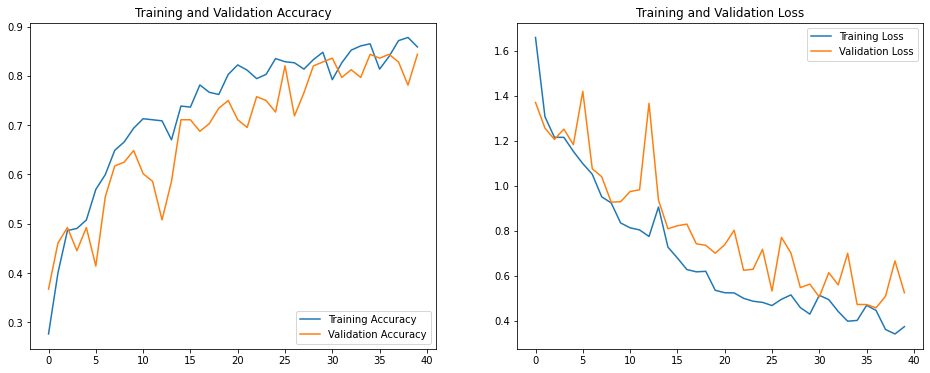

In [52]:
visualize_train_result(history4)

### Findings:
- After adding new layer we can see that validation accuracy has increased from 80% to 84%.
- Also model is not overfitting, but model is fluctuating more.
- Let's use augumentation to increase data and check the result.

## Data Augmentation.

In [53]:
!pip install Augmentor

In [54]:
import Augmentor

In [55]:
path_to_training_dataset = data_dir_path
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.6, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.6, min_factor=1.1, max_factor=1.6)
    p.crop_centre(probability=0.2, percentage_area=0.25, randomise_percentage_area=False)
    p.sample(400) ## We are adding 400 samples per class to make sure that none of the classes are sparse.

Initialised with 159 image(s) found.
Output directory set to ./newrecipes/briyani/output.

Processing <PIL.Image.Image image mode=RGB size=1290x1934 at 0x7FF2185BF250>: 100%|██████████| 400/400 [00:35<00:00, 11.37 Samples/s]                  


Initialised with 131 image(s) found.
Output directory set to ./newrecipes/burger/output.

Processing <PIL.Image.Image image mode=RGB size=300x168 at 0x7FF218514DD0>: 100%|██████████| 400/400 [00:52<00:00,  7.62 Samples/s]                    


Initialised with 136 image(s) found.
Output directory set to ./newrecipes/dosa/output.

Processing <PIL.Image.Image image mode=RGB size=1973x1314 at 0x7FF21856EF90>: 100%|██████████| 400/400 [00:37<00:00, 10.71 Samples/s]                  


Initialised with 136 image(s) found.
Output directory set to ./newrecipes/idly/output.

Processing <PIL.Image.Image image mode=RGB size=324x240 at 0x7FF2185F4210>: 100%|██████████| 400/400 [00:30<00:00, 13.29 Samples/s]                    


Initialised with 129 image(s) found.
Output directory set to ./newrecipes/pizza/output.

Processing <PIL.Image.Image image mode=RGB size=800x449 at 0x7FF2185D6E90>: 100%|██████████| 400/400 [00:41<00:00,  9.72 Samples/s]                    


**Use augumented data for training**

In [56]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_path,
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2691 files belonging to 5 classes.


In [58]:
train_ds, test_ds, val_ds = get_dataset_partition_tf(dataset)

In [59]:
print("Training size:", len(train_ds)*BATCH_SIZE)
print("Validation size:", len(val_ds)*BATCH_SIZE)
print("Testing size:", len(test_ds)*BATCH_SIZE)

Training size: 1888
Validation size: 544
Testing size: 288


In [66]:
def aug_model1():
    model = Sequential([
        resize_and_rescale,
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(256, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.build(input_shape)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [67]:
aug_model_1 = aug_model1()

In [68]:
%%time
EPOCHS = 10

aug_history1 = aug_model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[LR]
)

Epoch 1/10


2021-10-28 13:56:44.956962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 73 of 10000


 5/59 [=>............................] - ETA: 1s - loss: 5.1537 - accuracy: 0.1813 

2021-10-28 13:56:45.546081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


58/59 [============================>.] - ETA: 0s - loss: 1.6563 - accuracy: 0.4122

2021-10-28 13:56:57.668143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 74 of 10000
2021-10-28 13:56:58.091640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


59/59 [==============================] - 24s 220ms/step - loss: 1.6485 - accuracy: 0.4120 - val_loss: 1.0974 - val_accuracy: 0.5754
Epoch 2/10
59/59 [==============================] - ETA: 0s - loss: 0.7516 - accuracy: 0.7209

2021-10-28 13:57:37.329578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 77 of 10000
2021-10-28 13:57:37.426781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


59/59 [==============================] - 22s 212ms/step - loss: 0.7516 - accuracy: 0.7209 - val_loss: 0.5706 - val_accuracy: 0.7776
Epoch 3/10
 3/59 [>.............................] - ETA: 1s - loss: 0.5767 - accuracy: 0.7917  

2021-10-28 13:57:47.714092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 76 of 10000
2021-10-28 13:57:47.781244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


59/59 [==============================] - 22s 207ms/step - loss: 0.5388 - accuracy: 0.8160 - val_loss: 0.4056 - val_accuracy: 0.8713
Epoch 4/10
59/59 [==============================] - 21s 200ms/step - loss: 0.4008 - accuracy: 0.8601 - val_loss: 0.2150 - val_accuracy: 0.9412
Epoch 5/10
 5/59 [=>............................] - ETA: 1s - loss: 0.2542 - accuracy: 0.9187

2021-10-28 13:59:09.558744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 79 of 10000
2021-10-28 13:59:09.581049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


58/59 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.9146

2021-10-28 13:59:21.723764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 76 of 10000
2021-10-28 13:59:21.791418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


59/59 [==============================] - 22s 214ms/step - loss: 0.2510 - accuracy: 0.9150 - val_loss: 0.2316 - val_accuracy: 0.9283
Epoch 6/10


2021-10-28 13:59:32.232284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 76 of 10000
2021-10-28 13:59:32.410935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


58/59 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9365

2021-10-28 13:59:44.434340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 75 of 10000
2021-10-28 13:59:44.704379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


59/59 [==============================] - 23s 216ms/step - loss: 0.1894 - accuracy: 0.9365 - val_loss: 0.1435 - val_accuracy: 0.9540
Epoch 7/10
59/59 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 0.9516

2021-10-28 14:00:24.671863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 73 of 10000
2021-10-28 14:00:25.204160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


59/59 [==============================] - 22s 221ms/step - loss: 0.1447 - accuracy: 0.9516 - val_loss: 0.0876 - val_accuracy: 0.9779
Epoch 8/10


2021-10-28 14:00:54.062758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 75 of 10000


 5/59 [=>............................] - ETA: 1s - loss: 0.0903 - accuracy: 0.9812 

2021-10-28 14:00:54.418873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


59/59 [==============================] - 23s 209ms/step - loss: 0.1068 - accuracy: 0.9704 - val_loss: 0.0498 - val_accuracy: 0.9864
Epoch 9/10


2021-10-28 14:01:34.942305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 75 of 10000


 5/59 [=>............................] - ETA: 1s - loss: 0.0743 - accuracy: 0.9812 

2021-10-28 14:01:35.273576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


59/59 [==============================] - 22s 206ms/step - loss: 0.0962 - accuracy: 0.9720 - val_loss: 0.0328 - val_accuracy: 0.9908
Epoch 10/10
59/59 [==============================] - 22s 207ms/step - loss: 0.0636 - accuracy: 0.9822 - val_loss: 0.0352 - val_accuracy: 0.9871
CPU times: user 4min 54s, sys: 24.2 s, total: 5min 18s
Wall time: 5min 53s


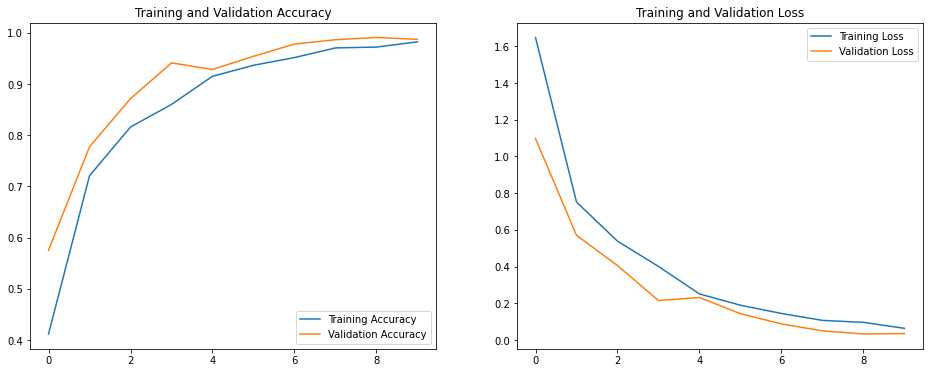

In [69]:
visualize_train_result(aug_history1)

### Findings:
- We can see that after using augumented data model is giving preety good accuracy.
- Model is no more overfitting.
- Also loss and accuracy is not fluctuating.

## Let's predict on test data


In [133]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

In [134]:
def predict_test(model):
    plt.figure(figsize=(15, 15))
    tak = test_ds.take(1)
    for images, labels in tak:
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)

            plt.imshow(images[i].numpy().astype("uint8"))
            image_1 = images[i].numpy()
            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]]

            plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")        
            plt.axis("off")

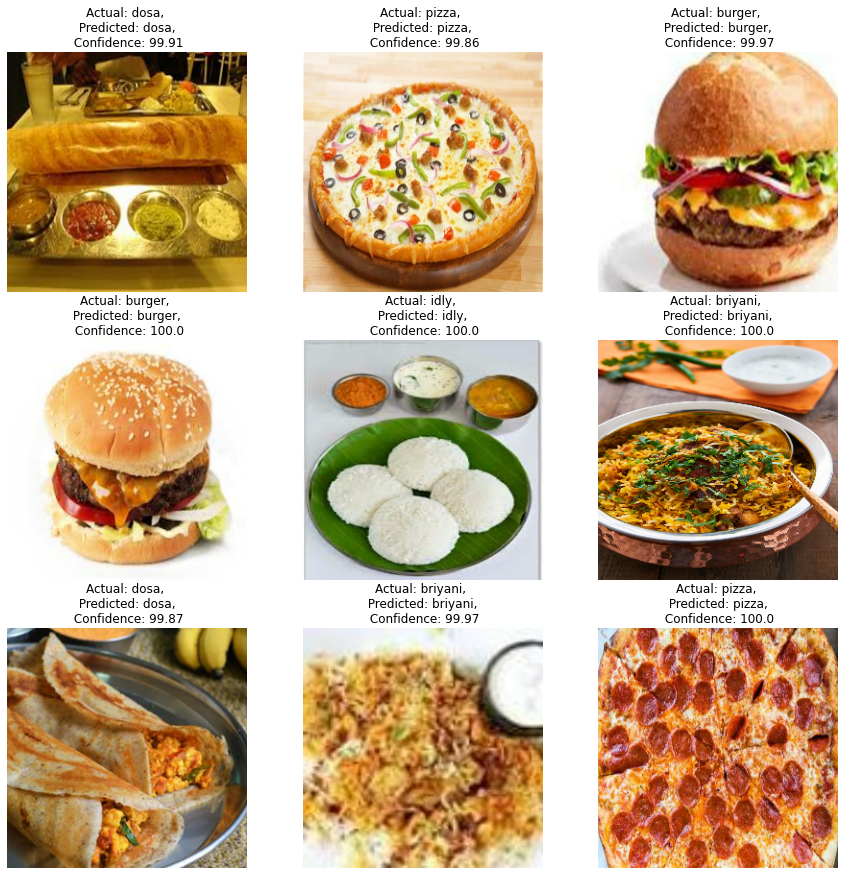

In [135]:
predict_test(aug_model_1)

## Save model

In [154]:
model_path = './models'

if not os.path.exists(model_path):
    os.mkdir('./models')

In [155]:
model_name_path = f'{model_path}/food_classifier_model'

aug_model_1.save(model_name_path)
aug_model_1.save(f'{model_name_path}_h5/my_model.h5')